## [SECTION 1]

**Importing packages and setting up training and test vectors**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import feature_extraction, linear_model, model_selection, preprocessing, svm
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, roc_curve
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [2]:
seed = 42

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
count_vectorizer = feature_extraction.text.CountVectorizer()

train_vectors = count_vectorizer.fit_transform(train_df["text"])
test_vectors = count_vectorizer.transform(test_df["text"])

## [SECTION 2]

**Dividing the train set in train and validation subsets**

In [5]:
# creating training set and validation set
m_total = len(train_df["target"])
m_validation = (m_total*20)/100
m_training = int(m_total - m_validation)

permutation = np.random.permutation(train_vectors.shape[0])

labels = train_df["target"]

train_vectors = train_vectors[permutation]
labels = labels[permutation]

X_train = train_vectors[:m_training]
y_train = labels[:m_training]

X_validation = train_vectors[m_training:]
y_validation = labels[m_training:]

In [6]:
# Checking if both labels are present in a fair amount in training and validation set

labels_train, freqs_train = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels_train)
print("Frequencies in training dataset: ", freqs_train)

labels_val, freqs_val = np.unique(y_validation, return_counts=True)
print("Labels in validation dataset: ", labels_val)
print("Frequencies in validation dataset: ", freqs_val)

print('Ratio of labels in training set:', freqs_train[0]/freqs_train[1])
print('Ratio of labels in validation set:', freqs_val[0]/freqs_val[1])

Labels in training dataset:  [0 1]
Frequencies in training dataset:  [3459 2631]
Labels in validation dataset:  [0 1]
Frequencies in validation dataset:  [883 640]
Ratio of labels in training set: 1.314709236031927
Ratio of labels in validation set: 1.3796875


## [SECTION 3]

**Trying various models for prediction**

## [SECTION 3.1]

**Logistic regression**

In [7]:
# Newton-cg as solver to solve convergence issues

log_regr = linear_model.LogisticRegression(solver='newton-cg') 

In [8]:
# Fitting with logistic regression

lr_fit = log_regr.fit(X_train, y_train)
log_reg_prediction = log_regr.predict(X_validation)

In [9]:
# LogisticRegression errors

training_error_log_reg = 1. - log_regr.score(X_train,y_train)
validation_error_log_reg = 1. - log_regr.score(X_validation,y_validation)

print ("LogisticRegression training error: %f" % training_error_log_reg)
print ("LogisticRegression validation error: %f" % validation_error_log_reg)

LogisticRegression training error: 0.027422
LogisticRegression validation error: 0.200263


In [10]:
# Confusion matrix and accuracy for logistic regression

con_mat_log_reg = confusion_matrix(log_reg_prediction, y_validation)

np.set_printoptions(precision=2, suppress=True) 

u, counts = np.unique(y_validation, return_counts=True)

norm_con_mat_logreg = con_mat_log_reg/counts[:,None]

accuracy_balanced = balanced_accuracy_score(y_validation, log_reg_prediction)
accuracy = accuracy_score(y_validation, log_reg_prediction)

print('Accuracy score on validation: ', accuracy, '\n')
print('Balanced accuracy on validation: ', accuracy_balanced, '\n')

Accuracy score on validation:  0.7997373604727511 

Balanced accuracy on validation:  0.7877335787089468 



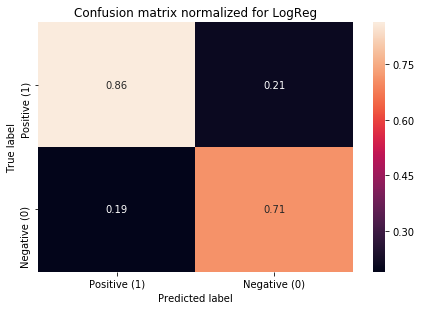

In [11]:
# Plotting confusion matrix for logistic regression

sns_plot = sn.heatmap(norm_con_mat_logreg, annot=True, xticklabels=['Positive (1)', 'Negative (0)'], yticklabels=['Positive (1)', 'Negative (0)'])
sns_heatmap = sns_plot.get_figure()
plt.tight_layout()
plt.title('Confusion matrix normalized for LogReg')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Best Threshold=0.514610, G-Mean=0.786


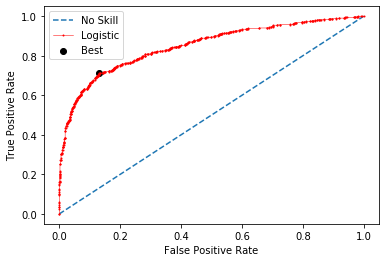

In [12]:
# Roc curve for logistic regression

yhat = log_regr.predict_proba(X_validation)
yhat = yhat[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

best_threshold = thresholds[ix]

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic', color='r', linewidth=0.5, markersize=2)
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [13]:
# Confusion matrix and accuracy for logistic regression (after roc curve)

roc_curve_logreg_prediction = np.where(log_regr.predict_proba(X_validation)[:,1] > best_threshold, 1, 0)

con_mat_log_reg = confusion_matrix(roc_curve_logreg_prediction, y_validation)

np.set_printoptions(precision=2, suppress=True) 

u, counts = np.unique(y_validation, return_counts=True)

norm_con_mat_logreg = con_mat_log_reg/counts[:,None]

accuracy_balanced = balanced_accuracy_score(y_validation, roc_curve_logreg_prediction)
accuracy = accuracy_score(y_validation, roc_curve_logreg_prediction)

print('Accuracy score on validation (roc curve): ', accuracy, '\n')
print('Balanced accuracy on validation (roc curve): ', accuracy_balanced, '\n')

Accuracy score on validation (roc curve):  0.8023637557452397 

Balanced accuracy on validation (roc curve):  0.789568587202718 



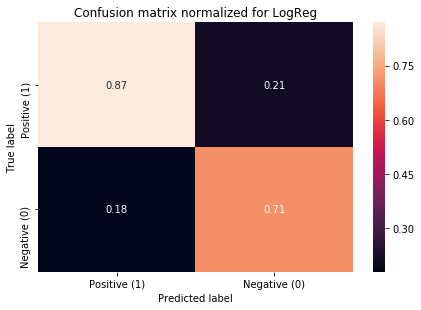

In [14]:
# Plotting confusion matrix for logistic regression (after roc curve)

sns_plot = sn.heatmap(norm_con_mat_logreg, annot=True, xticklabels=['Positive (1)', 'Negative (0)'], yticklabels=['Positive (1)', 'Negative (0)'])
sns_heatmap = sns_plot.get_figure()
plt.tight_layout()
plt.title('Confusion matrix normalized for LogReg')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## [SECTION 3.2]

**Support vector machine**

In [15]:
# SVM with linear kernel. Parameters are chosen after a gridsearch hyperparameter optimization

swag_SVM = svm.SVC(kernel='linear', C=0.08, gamma='auto', probability=True)

In [16]:
# Fitting with SVM

swag_SVM.fit(X_train, y_train)

svm_prediction = swag_SVM.predict(X_validation)

In [17]:
# SVM errors

training_error = 1. - swag_SVM.score(X_train,y_train)
validation_error = 1. - swag_SVM.score(X_validation,y_validation)

print ("SVM training error: %f" % training_error)
print ("SVM validation error: %f" % validation_error)

SVM training error: 0.086535
SVM validation error: 0.193040


In [18]:
# Confusion matrix and accuracy for SVM

con_mat_svm = confusion_matrix(svm_prediction, y_validation)

np.set_printoptions(precision=2, suppress=True) 

u, counts = np.unique(y_validation, return_counts=True)

norm_con_mat_svm = con_mat_svm/counts[:,None]

accuracy_balanced = balanced_accuracy_score(y_validation, svm_prediction)
accuracy = accuracy_score(y_validation, svm_prediction)

print('Accuracy score on validation: ', accuracy, '\n')
print('Balanced accuracy on validation: ', accuracy_balanced, '\n')

Accuracy score on validation:  0.8069599474720945 

Balanced accuracy on validation:  0.7900923697621745 



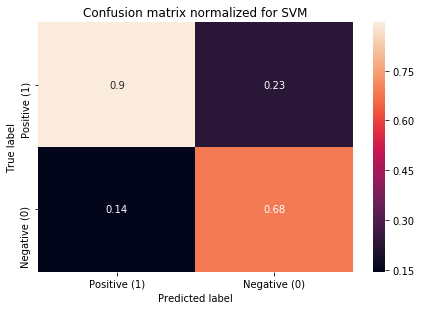

In [19]:
# Plotting confusion matrix for logistic regression

sns_plot = sn.heatmap(norm_con_mat_svm, annot=True, xticklabels=['Positive (1)', 'Negative (0)'], yticklabels=['Positive (1)', 'Negative (0)'])
sns_heatmap = sns_plot.get_figure()
plt.tight_layout()
plt.title('Confusion matrix normalized for SVM')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Best Threshold=0.436062, G-Mean=0.791


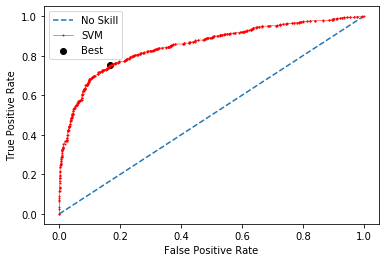

In [20]:
# Roc curve for SVM

yhat = swag_SVM.predict_proba(X_validation)
yhat = yhat[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

best_threshold = thresholds[ix]

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='SVM', color='r', linewidth=0.5, markersize=2)
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [21]:
# Confusion matrix and accuracy for SVM (after roc curve)

roc_svm_prediction = np.where(swag_SVM.predict_proba(X_validation)[:,1] > best_threshold, 1, 0)

con_mat_svm = confusion_matrix(roc_svm_prediction, y_validation)

np.set_printoptions(precision=2, suppress=True) 

u, counts = np.unique(y_validation, return_counts=True)

norm_con_mat_svm = con_mat_svm/counts[:,None]

accuracy_balanced = balanced_accuracy_score(y_validation, roc_svm_prediction)
accuracy = accuracy_score(y_validation, roc_svm_prediction)

print('Accuracy score on validation (roc curve): ', accuracy, '\n')
print('Balanced accuracy on validation (roc curve): ', accuracy_balanced, '\n')

Accuracy score on validation (roc curve):  0.7984241628365069 

Balanced accuracy on validation (roc curve):  0.7917610419026048 



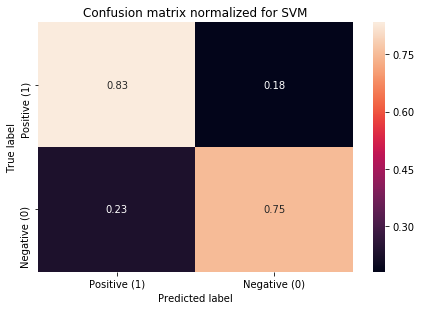

In [22]:
# Plotting confusion matrix for SVM

sns_plot = sn.heatmap(norm_con_mat_svm, annot=True, xticklabels=['Positive (1)', 'Negative (0)'], yticklabels=['Positive (1)', 'Negative (0)'])
sns_heatmap = sns_plot.get_figure()
plt.tight_layout()
plt.title('Confusion matrix normalized for SVM')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## [SECTION 3.3]

**Gaussian naive bayes**

In [23]:
positive_class = len(y_train[y_train==1])
negative_class = len(y_train[y_train==0])
total = positive_class + negative_class

positive_perc = ((positive_class*100)/total)/100
negative_perc = ((negative_class*100)/total)/100

In [24]:
naive_by = GaussianNB()

In [25]:
naive_by.fit(X_train.toarray(), y_train)
by_prediction = naive_by.predict(X_validation.toarray())

In [26]:
training_error = 1. - naive_by.score(X_train.toarray(),y_train)
validation_error = 1. - naive_by.score(X_validation.toarray(),y_validation)

print ("Naive Bayes training error: %f" % training_error)
print ("Naive Bayes validation error: %f" % validation_error)

Naive Bayes training error: 0.041872
Naive Bayes validation error: 0.381484


In [27]:
# Confusion matrix and accuracy for NaiveBayes

con_mat_nb = confusion_matrix(by_prediction, y_validation)

np.set_printoptions(precision=2, suppress=True) 

u, counts = np.unique(y_validation, return_counts=True)

norm_con_mat_nb = con_mat_nb/counts[:,None]

accuracy_balanced = balanced_accuracy_score(y_validation, by_prediction)
accuracy = accuracy_score(y_validation, by_prediction)

print('Accuracy score on validation: ', accuracy, '\n')
print('Balanced accuracy on validation: ', accuracy_balanced, '\n')

Accuracy score on validation:  0.618516086671044 

Balanced accuracy on validation:  0.6432731101359004 



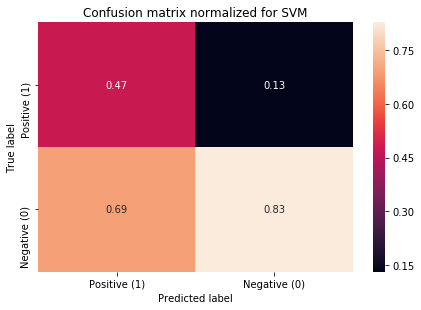

In [28]:
# Plotting confusion matrix for NaiveBayes

sns_plot = sn.heatmap(norm_con_mat_nb, annot=True, xticklabels=['Positive (1)', 'Negative (0)'], yticklabels=['Positive (1)', 'Negative (0)'])
sns_heatmap = sns_plot.get_figure()
plt.tight_layout()
plt.title('Confusion matrix normalized for GaussianNB')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Best Threshold=1.000000, G-Mean=0.626


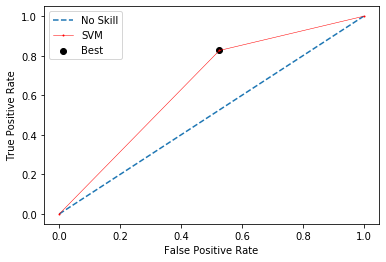

In [29]:
# Roc curve for NaiveBayes

yhat = naive_by.predict_proba(X_validation.toarray())
yhat = yhat[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

best_threshold = thresholds[ix]

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='SVM', color='r', linewidth=0.5, markersize=2)
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [30]:
# Confusion matrix and accuracy for NaiveBayes (after roc curve)

roc_nb_prediction = np.where(naive_by.predict_proba(X_validation.toarray())[:,1] > best_threshold, 1, 0)

con_mat_nb = confusion_matrix(roc_nb_prediction, y_validation)

np.set_printoptions(precision=2, suppress=True) 

u, counts = np.unique(y_validation, return_counts=True)

norm_con_mat_nb = con_mat_nb/counts[:,None]

accuracy_balanced = balanced_accuracy_score(y_validation, roc_nb_prediction)
accuracy = accuracy_score(y_validation, roc_nb_prediction)

print('Accuracy score on validation (roc curve): ', accuracy, '\n')
print('Balanced accuracy on validation (roc curve): ', accuracy_balanced, '\n')

Accuracy score on validation (roc curve):  0.5679579776756402 

Balanced accuracy on validation (roc curve):  0.5 



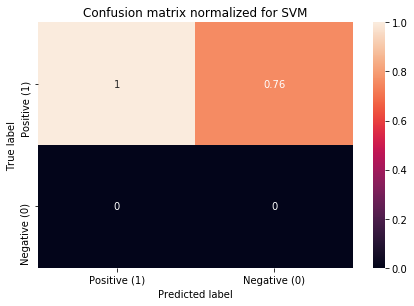

In [31]:
# Plotting confusion matrix for NaiveBayes

sns_plot = sn.heatmap(norm_con_mat_nb, annot=True, xticklabels=['Positive (1)', 'Negative (0)'], yticklabels=['Positive (1)', 'Negative (0)'])
sns_heatmap = sns_plot.get_figure()
plt.tight_layout()
plt.title('Confusion matrix normalized for GaussianNB')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## [SECTION 3.4]

**Neural network**

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


def nn_model():
    
    model = Sequential()
    model.add(Dense(16, input_dim=21637, activation='relu'))

    model.add(Dropout(0.33))

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.33))

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.33))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.33))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.33))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.33))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = nn_model()

In [29]:
model.fit(X_train, y_train, epochs=20, batch_size=64)

Train on 6090 samples
Epoch 1/20
6090/6090 [==============================] - 5s 829us/sample - loss: 0.6820 - accuracy: 0.5611
Epoch 2/20
6090/6090 [==============================] - 3s 466us/sample - loss: 0.6341 - accuracy: 0.5594 - loss: 0.6374 - accura
Epoch 3/20
6090/6090 [==============================] - 3s 422us/sample - loss: 0.5510 - accuracy: 0.7811
Epoch 4/20
6090/6090 [==============================] - 3s 434us/sample - loss: 0.4800 - accuracy: 0.8703
Epoch 5/20
6090/6090 [==============================] - 3s 452us/sample - loss: 0.4165 - accuracy: 0.8967
Epoch 6/20
6090/6090 [==============================] - 3s 458us/sample - loss: 0.3619 - accuracy: 0.9184
Epoch 7/20
6090/6090 [==============================] - 3s 431us/sample - loss: 0.3214 - accuracy: 0.9264
Epoch 8/20
6090/6090 [==============================] - 3s 426us/sample - loss: 0.3010 - accuracy: 0.9319
Epoch 9/20
6090/6090 [==============================] - 3s 456us/sample - loss: 0.2652 - accuracy: 0.9442


In [30]:
val_loss, val_acc = model.evaluate(X_validation, y_validation)
print('val_acc:', val_acc, 'val_loss', val_loss)

1523/1523 [==============================] - 1s 493us/sample - loss: 1.4491 - accuracy: 0.7242
val_acc: 0.7242285 val_loss 1.4491419073632104


In [31]:
nn_pred = model.predict_classes(X_validation.toarray())

In [32]:
# Confusion matrix and accuracy for NN

con_mat_nn = confusion_matrix(nn_pred, y_validation)

np.set_printoptions(precision=2, suppress=True) 

u, counts = np.unique(y_validation, return_counts=True)

norm_con_mat_nn = con_mat_nb/counts[:,None]

accuracy_balanced = balanced_accuracy_score(y_validation, nn_pred)
accuracy = accuracy_score(y_validation, nn_pred)

print('Accuracy score on validation: ', accuracy, '\n')
print('Balanced accuracy on validation: ', accuracy_balanced, '\n')

Accuracy score on validation:  0.7242284963887065 

Balanced accuracy on validation:  0.7307846121177803 



## [SECTION 4]

**Prediction**

In [37]:
# SVM for prediction

final_svm = svm.SVC(kernel='linear', C=0.08, gamma='auto', probability=True)

final_svm.fit(train_vectors, labels)

test_prediction = final_svm.predict(test_vectors)
#test_prediction = np.where(final_svm.predict_proba(test_vectors)[:,1] > best_threshold, 1, 0)

In [38]:
test_id = test_df['id']

In [39]:
submission_df = pd.DataFrame()
submission_df['id'] = test_id
submission_df['target'] = test_prediction

In [40]:
submission_df.to_csv('submission5.csv', index=False)